# Test Data

In [1]:
import sys
from pyprojroot import here
# root = here(project_files=[".here"])
root = "/home/emmanuel/code/jaxkern"
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist
from sklearn.model_selection import train_test_split

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.linear import TaylorFirstOrder, TaylorSecondOrder

# MATPLOTLIB Settings
# import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
!ls $data_dir

exact_gp.ipynb		  uncertain_mc.ipynb	      uncertain_taylor.ipynb
gp_gradients.ipynb	  uncertain_mm.ipynb	      uncertain_unscented.ipynb
kernel_quadratures.ipynb  uncertain_quadrature.ipynb


In [3]:
from pathlib import Path
import pandas as pd

data_dir = Path("/media/disk/erc/papers/2020_LAI_FAPAR_errorPropagarion_IGARSS_ANN_MODIS/Data")

# load trainind data
data_file = "trainingdataRegressionaddedpredictionerror.csv"
data_df = pd.read_csv(str(data_dir.joinpath(data_file)))

In [4]:
data_df.head()

,system:index,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,...,P1_postSD,P2_postSD,P3_postSD,P4_postSD,P5_postSD,P7_postSD,latitude,longitude,month,.geo
0,0_0,830.0,1065.0,1248.0,2101.0,2143.0,1366.0,18.0,9.0,2.0,...,155.0,161.0,170.0,188.0,236.0,174.0,37.155892,-104.733007,1.0,"{""type"":""Point"",""coordinates"":[-104.7330069237..."
1,0_1,1084.0,1367.0,1625.0,2562.0,3474.0,2688.0,20.0,0.0,3.0,...,170.0,185.0,237.0,282.0,362.0,278.0,47.937023,-111.795113,1.0,"{""type"":""Point"",""coordinates"":[-111.7951125298..."
2,0_2,774.0,961.0,1238.0,1806.0,2237.0,1640.0,NaN,NaN,NaN,...,320.0,381.0,428.0,376.0,433.0,424.0,48.397859,-109.891133,1.0,"{""type"":""Point"",""coordinates"":[-109.8911332851..."
3,0_3,NaN,1514.0,1592.0,1814.0,1254.0,830.0,9.0,0.0,1.0,...,NaN,2093.0,1098.0,1343.0,1081.0,764.0,43.983538,-92.334909,1.0,"{""type"":""Point"",""coordinates"":[-92.33490852997..."
4,0_4,806.0,1051.0,1238.0,2339.0,2695.0,1821.0,30.0,0.0,3.0,...,62.0,68.0,90.0,220.0,244.0,192.0,41.339796,-82.309710,1.0,"{""type"":""Point"",""coordinates"":[-82.30970995919..."


In [5]:
data_df.describe()

,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,Lai_stdDev,Land_Cover_Type_1,P1_postSD,P2_postSD,P3_postSD,P4_postSD,P5_postSD,P7_postSD,latitude,longitude,month
count,44998.000000,45186.000000,45198.000000,45855.000000,45618.000000,45444.000000,45760.000000,45760.000000,45760.000000,45760.000000,60000.000000,45232.000000,45410.000000,45427.000000,45860.000000,45613.000000,45443.000000,60000.000000,60000.000000,60000.000000
mean,662.822325,895.831319,1015.383667,2460.599084,2291.759854,1545.499164,43.480223,4.770935,12.854524,2.540363,7.524000,110.629024,123.809998,150.295463,263.921718,263.850766,206.575446,39.461816,-95.324458,6.500000
std,311.350921,399.668849,564.495663,667.838590,743.026212,748.526390,24.322966,4.416876,13.866046,4.047343,4.682498,187.425222,133.546410,156.164522,255.724349,226.034405,280.588662,5.646239,15.320763,3.452081
min,151.000000,207.000000,149.000000,421.000000,98.000000,94.000000,5.000000,0.000000,1.000000,0.000000,0.000000,9.000000,10.000000,12.000000,5.000000,6.000000,4.000000,24.620352,-124.686386,1.000000
25%,430.000000,603.000000,574.000000,1993.000000,1760.000000,946.000000,23.000000,2.000000,3.000000,0.000000,4.000000,65.000000,72.000000,85.000000,161.000000,160.000000,115.000000,35.032612,-107.921465,3.750000
50%,602.000000,815.000000,907.000000,2358.000000,2267.000000,1456.500000,41.000000,4.000000,7.000000,1.000000,8.000000,83.000000,94.000000,117.000000,211.000000,212.000000,161.000000,39.603577,-94.248994,6.500000
75%,817.000000,1082.000000,1327.000000,2844.000000,2808.000000,2024.000000,62.000000,7.000000,17.000000,3.000000,12.000000,109.000000,126.000000,163.000000,286.000000,294.000000,239.000000,44.157362,-82.687676,9.250000
max,3688.000000,3604.000000,3896.000000,6402.000000,5023.000000,4906.000000,97.000000,39.000000,68.000000,32.000000,16.000000,29955.000000,4124.000000,4483.000000,5047.000000,5033.000000,32767.000000,49.691433,-62.849506,12.000000


In [6]:
x_columns = [
    "B1_post",
    "B2_post",
    "B3_post",
    "B4_post",
    "B5_post",
    "B7_post",
]
x_std_columns = [
    "P1_postSD",
    "P2_postSD",
    "P3_postSD",
    "P4_postSD",
    "P5_postSD",
    "P7_postSD"
]
y_columns = [
    "Lai",
    "Fpar",
]
y_std_columns = [
    "Lai_stdDev",
    "Fpar_stdDev"
]
meta = [
    "latitude",
    "longitude",
    "month",
    "Land_Cover_Type_1"
]

In [ ]:
data_train_l_.sort_values

In [11]:
# data_train = data_train_l_.sort_values(['latitude', 'longitude', "month", "Land_Cover_Type_1"], ascending=[True, True, True, True])
data_train = data_train_l_.set_index(meta).sort_index()

In [22]:
X = data_df[x_columns]
y = data_df[y_columns]

X.shape, y.shape

((60000, 6), (60000, 2))

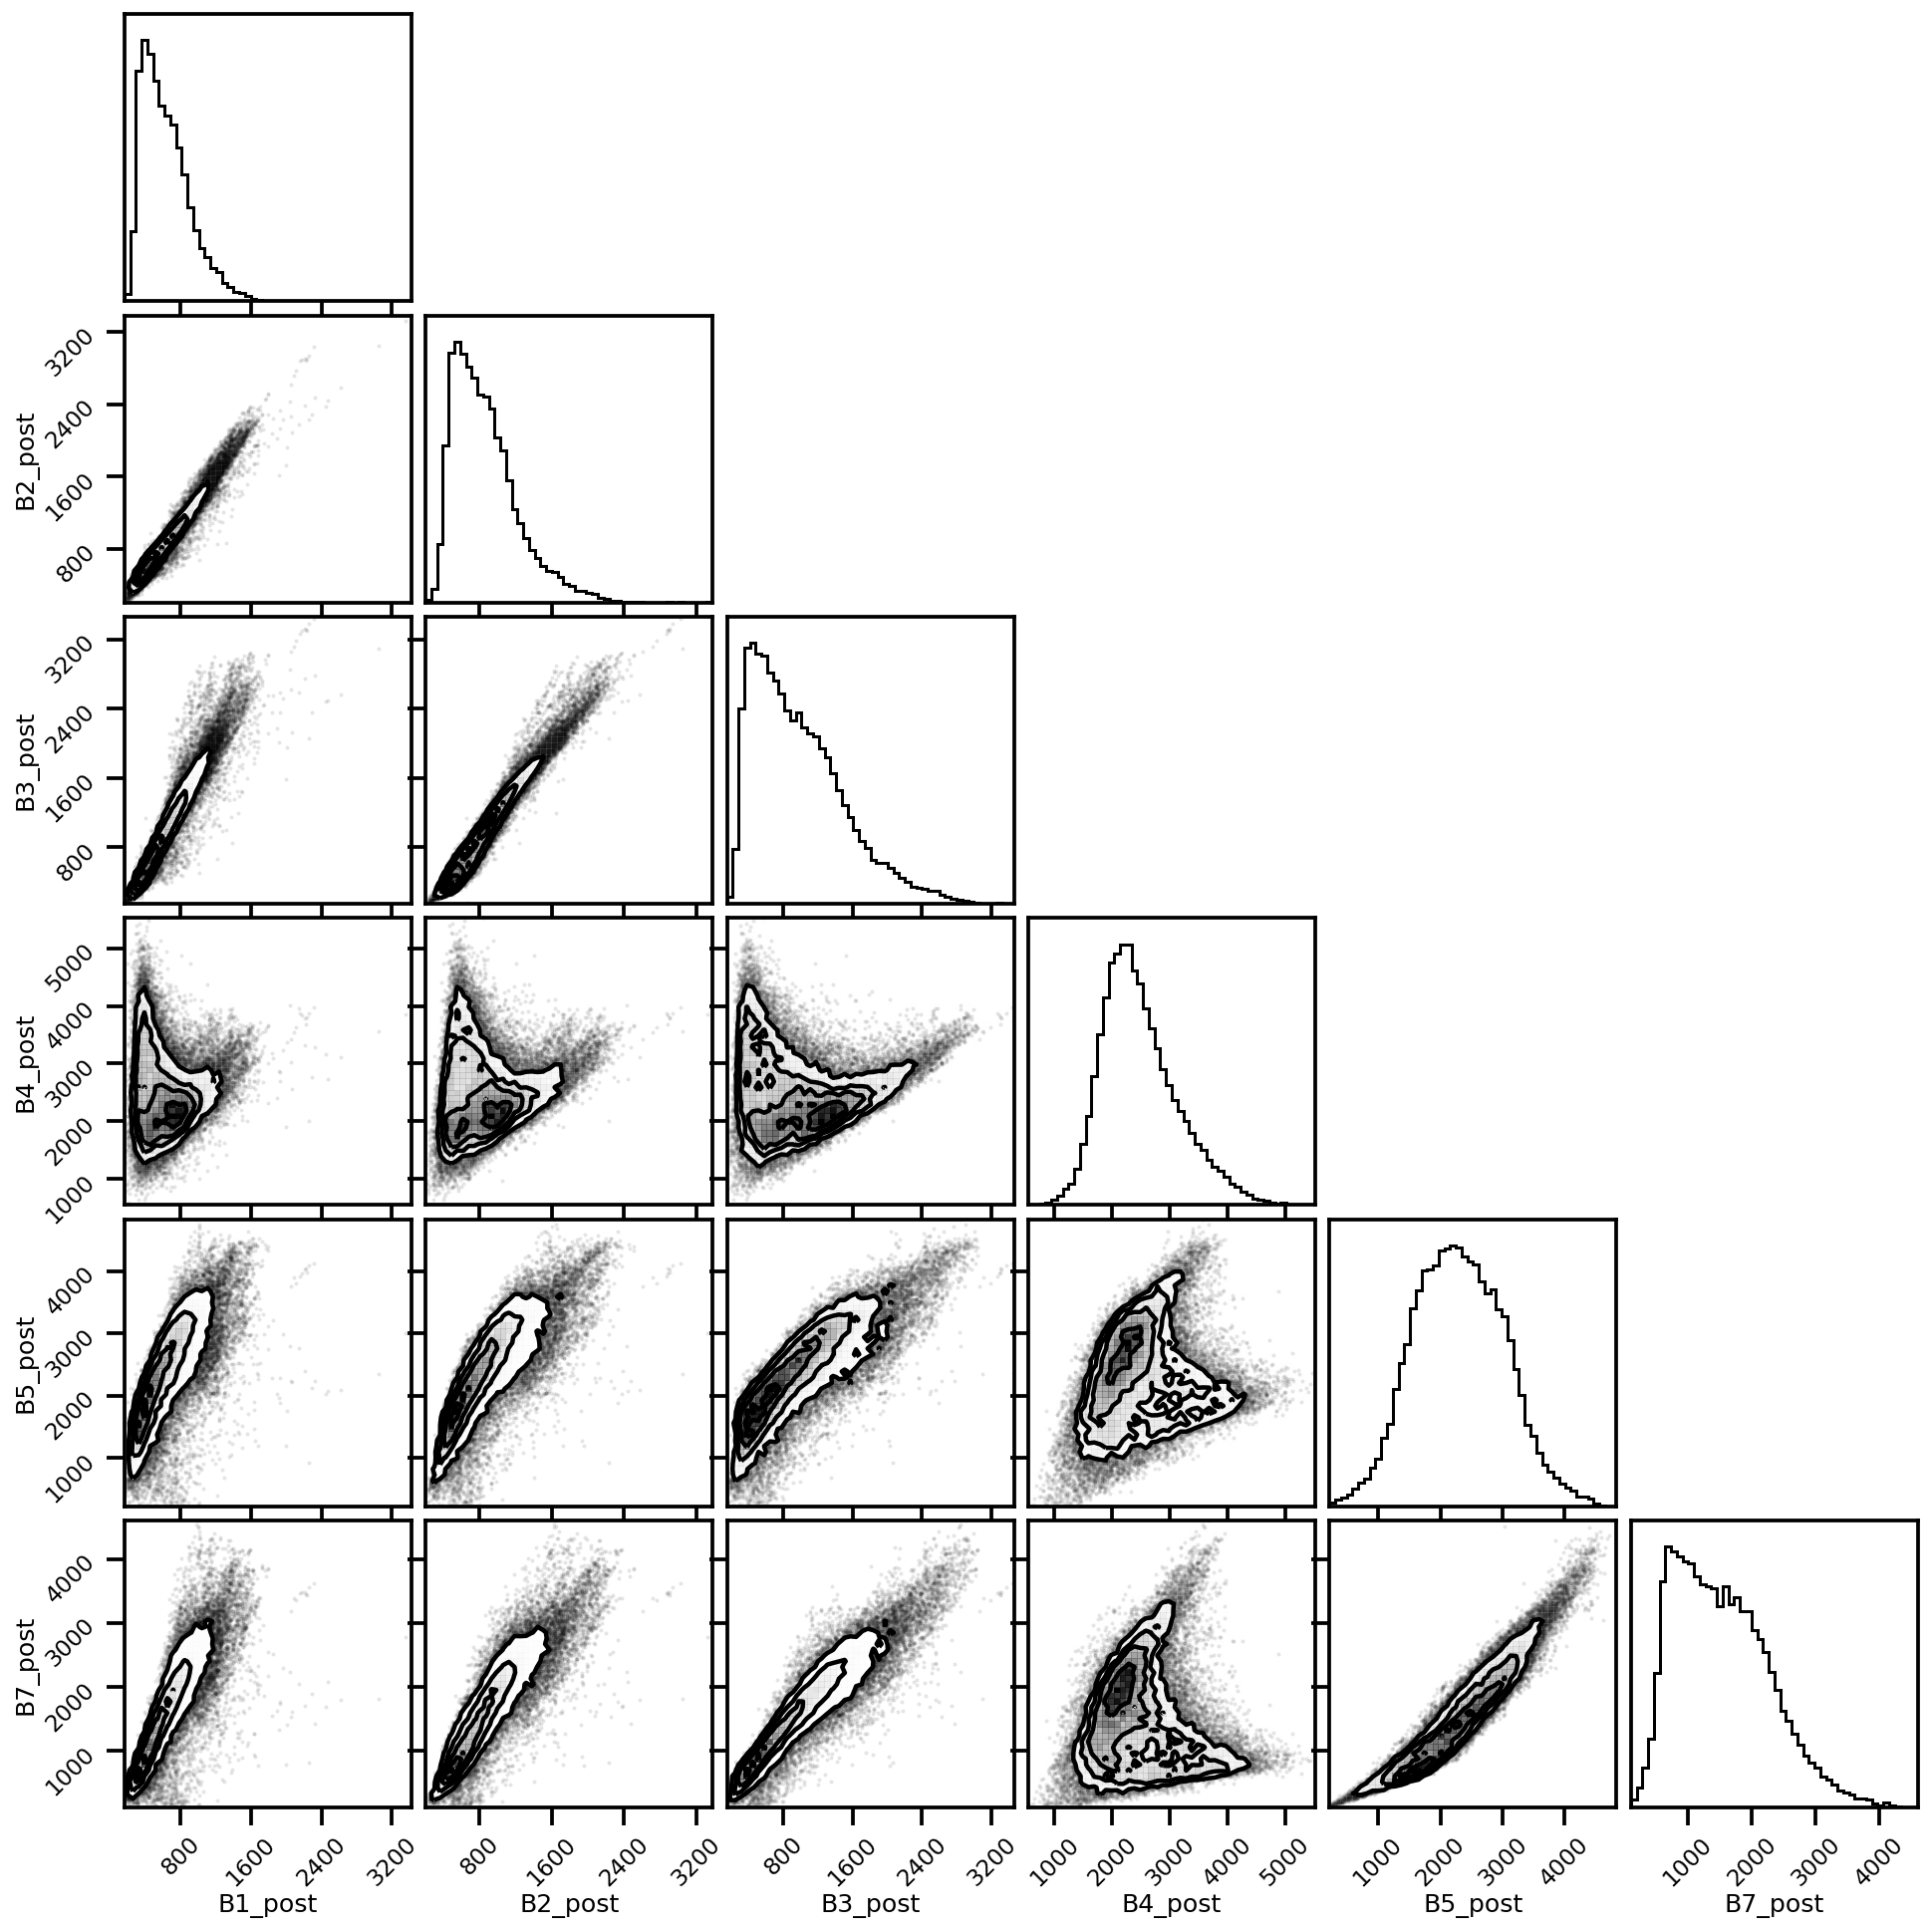

In [178]:
figure = corner.corner(X.dropna(), bins=50);

### Train-Test Split

In [16]:
ytrain.index

MultiIndex([( 35.05787685686948, -102.66733092791495,  4.0, 10),
            (38.764774876788685,  -77.22434713579777, 12.0, 14),
            ( 48.49083445795075, -118.90976958008005,  7.0,  1),
            ( 35.20340393289684,  -103.5687903155289, 10.0,  7),
            (36.019972526161474,  -83.46988414863874, 10.0, 14),
            ( 41.10937776834064,  -76.93329298374303,  1.0, 14),
            ( 44.17757362125086, -102.73605204715011,  9.0, 10),
            (45.362002323362454,  -106.2691260595922,  8.0, 10),
            ( 36.31506909699475,  -97.26261702100986,  2.0, 10),
            (41.675316397335926,  -94.76440221587349, 10.0, 12),
            ...
            ( 33.11751584317131,  -85.31726953043052,  8.0,  5),
            (39.791549246537286, -104.74109176130487,  4.0, 12),
            ( 26.39497341446287,  -81.35974154624199,  1.0, 14),
            ( 39.37922253112644, -120.72481561164355,  6.0,  1),
            (40.074518561034935, -110.82088960422578, 10.0, 10),
         

In [17]:
!pip install xarray

     |████████████████████████████████| 720 kB 1.3 MB/s eta 0:00:01


In [206]:
ytest.shape, ytrain.shape

((40430,), (1000,))

In [7]:
import xarray as xr

In [8]:
xr_data_train = ytrain.to_xarray()
xr_data_train = xr_data_train.reindex(
    latitude=sorted(xr_data_train.latitude), 
    longitude=sorted(xr_data_train.longitude),
    month=sorted(xr_data_train.month),
    Land_Cover_Type_1=sorted(xr_data_train.Land_Cover_Type_1),
)

xr_data_test = ytest.to_xarray()
xr_data_test = xr_data_test.reindex(
    latitude=sorted(xr_data_test.latitude), 
    longitude=sorted(xr_data_test.longitude),
    month=sorted(xr_data_test.month),
    Land_Cover_Type_1=sorted(xr_data_test.Land_Cover_Type_1),
)

NameError: name 'ytrain' is not defined

In [20]:
xr_data_test

<xarray.DataArray 'Lai' (latitude: 2597, longitude: 3265, month: 12, Land_Cover_Type_1: 15)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * latitude           (latitude) float64 25.33 25.53 25.59 ... 48.95 48.98
  * longitude          (longitude) float64 -124.2 -124.2 ... -67.88 -67.65
  * month              (month) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
  * Land_Cover_Type_1  (Land_Cover_Type_1) int64 0 1 2 3 4 5 ... 10 11 12 14 16

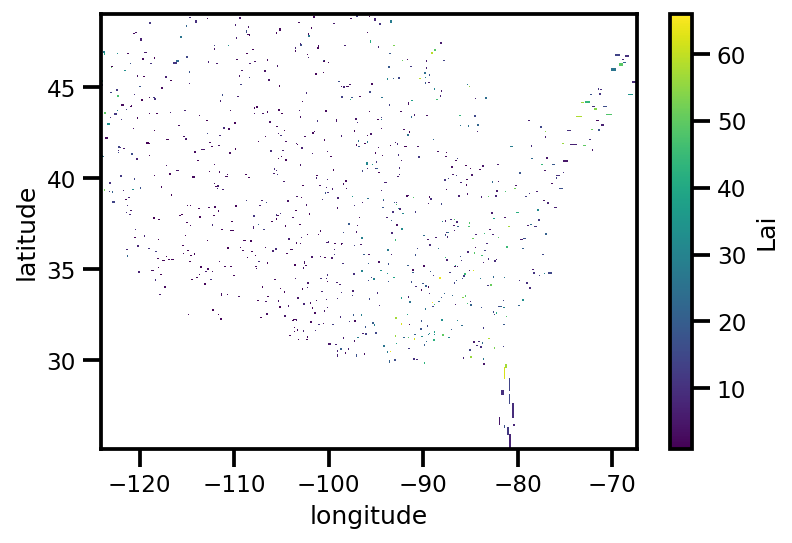

In [22]:
xr_data_train.mean(dim=['month', 'Land_Cover_Type_1'], skipna=True).plot.pcolormesh()

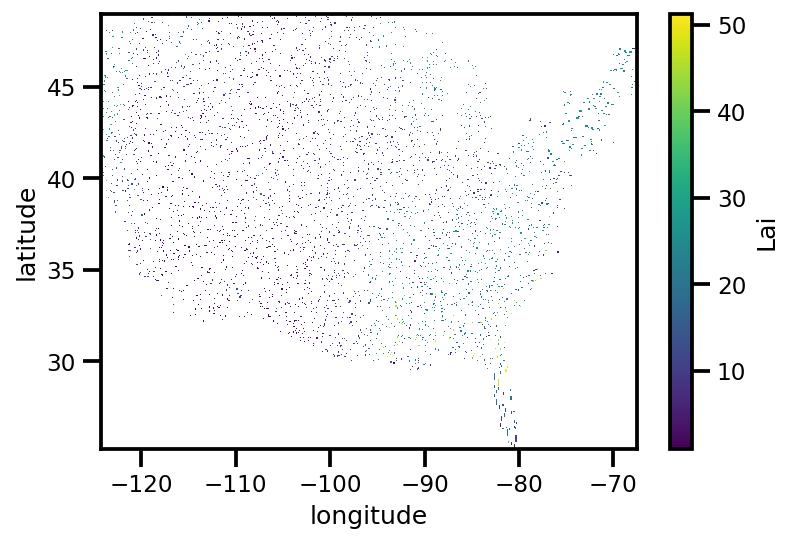

In [23]:
xr_data_test.mean(dim=['month', 'Land_Cover_Type_1'], skipna=True).plot.pcolormesh()

In [123]:
X = data_df.dropna()[x_columns]
y = data_df.dropna()[y_columns]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y['Lai'], train_size=5_000, random_state=123)

In [124]:
from sklearn.preprocessing import StandardScaler
import numpy as onp

x_transformer = StandardScaler()

Xtrain_scaled = x_transformer.fit_transform(Xtrain)
Xtest_scaled = x_transformer.transform(Xtest)

y_transformer = StandardScaler(with_std=False)

ytrain_scaled = y_transformer.fit_transform(onp.array(ytrain)[:, None])
ytest_scaled = y_transformer.transform(onp.array(ytest)[:, None])


### Linear Regression

In [125]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, PoissonRegressor
import numpy as onp

In [126]:
linear_model = LinearRegression(n_jobs=-1)

linear_model.fit(Xtrain_scaled, ytrain_scaled)

mu_train = linear_model.predict(Xtrain_scaled)

0.6988052831268737

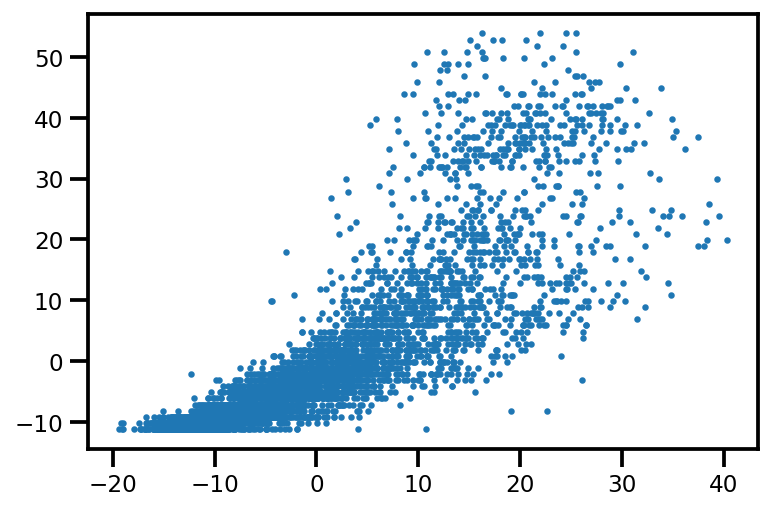

In [127]:
plt.scatter(mu_train, ytrain_scaled, s=3)
r2_score(ytrain_scaled, mu_train)


0.6995125647652012

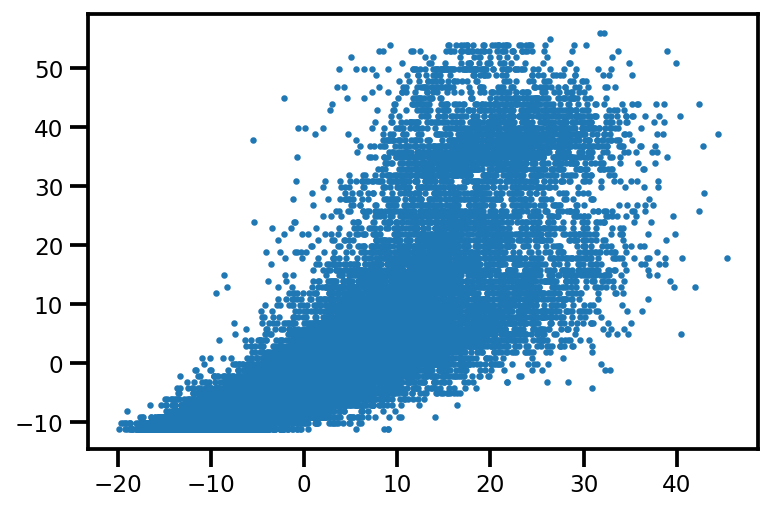

In [128]:
mu_test = linear_model.predict(Xtest_scaled)

plt.scatter(mu_test, ytest_scaled, s=3)
r2_score(ytest_scaled, mu_test)

### Polynomial Features

In [129]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [130]:
degrees=2
polynomial_features = PolynomialFeatures(degree=degrees,
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(Xtrain_scaled, ytrain_scaled)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('linear_regression', LinearRegression())])

0.7836977321053937

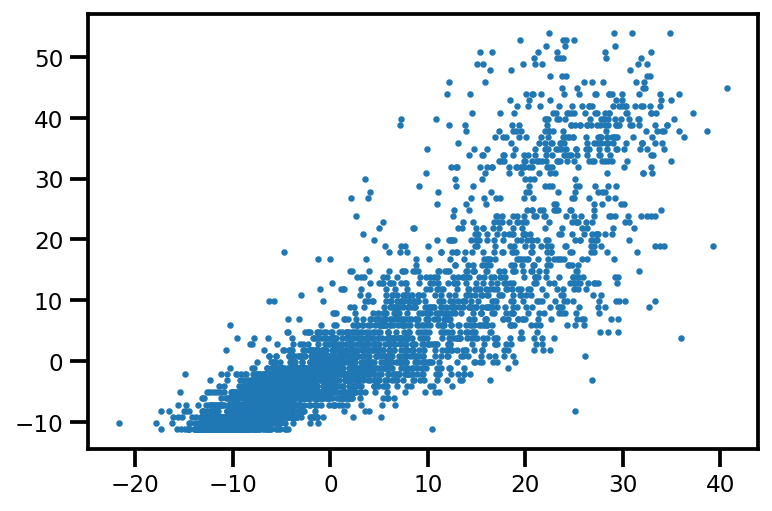

In [131]:
mu_train = pipeline.predict(Xtrain_scaled)

plt.scatter(mu_train, ytrain_scaled, s=3)
r2_score(ytrain_scaled, mu_train)

0.7804784209832878

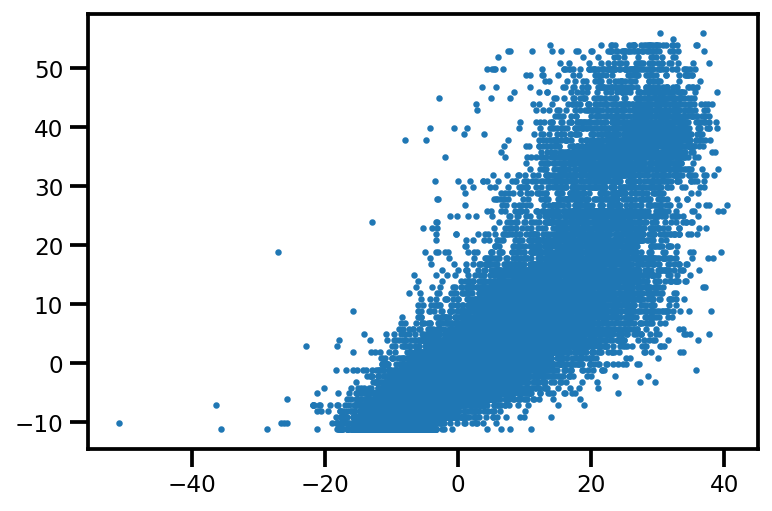

In [132]:
mu_test = pipeline.predict(Xtest_scaled)

plt.scatter(mu_test, ytest_scaled, s=3)
r2_score(ytest_scaled, mu_test)

### Quantile Regression

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
alpha = 0.95
loss = "ls"

clf = GradientBoostingRegressor(loss=loss, alpha=alpha,
                                n_estimators=1_000, max_depth=3,
                                learning_rate=.01, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(onp.array(Xtrain), onp.array(ytrain))

GradientBoostingRegressor(alpha=0.95, min_samples_leaf=9, min_samples_split=9,
                          n_estimators=1000)

0.9030980207953389

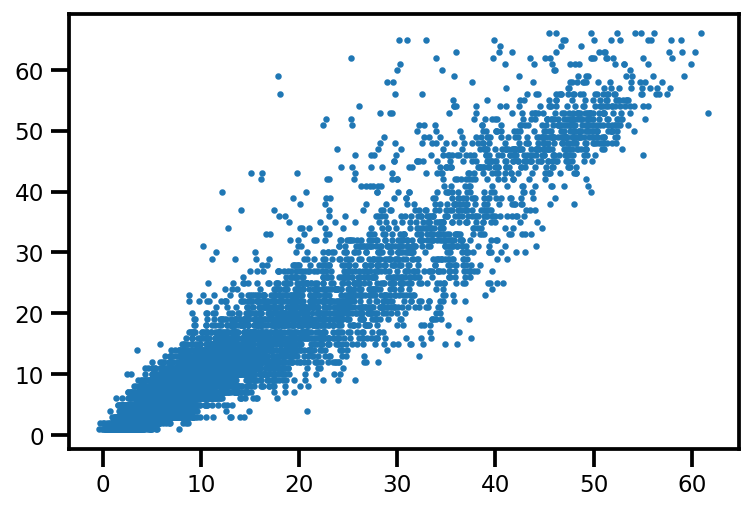

In [52]:
mu_train = clf.predict(onp.array(Xtrain))

plt.scatter(mu_train, ytrain, s=3)
r2_score(ytrain, mu_train)

0.7886649868765289

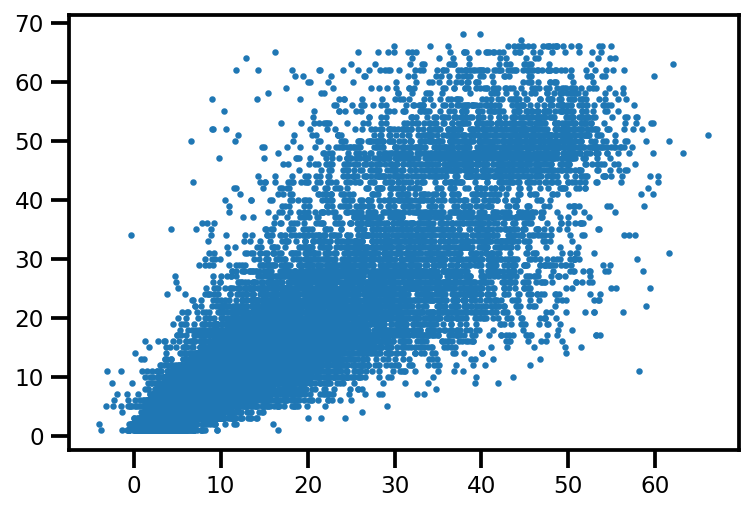

In [53]:
mu_test = clf.predict(onp.array(Xtest))

plt.scatter(mu_test, ytest, s=3)
r2_score(ytest, mu_test)

### GP Model

In [151]:
X = data_df.dropna()[x_columns]
y = data_df.dropna()[y_columns]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y['Lai'], train_size=3_000, random_state=123)

# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y['Lai'], train_size=1000, random_state=123)

In [152]:
from sklearn.preprocessing import StandardScaler
import numpy as onp

x_transformer = StandardScaler()

Xtrain_scaled = x_transformer.fit_transform(Xtrain)
Xtest_scaled = x_transformer.transform(Xtest)

y_transformer = StandardScaler(with_std=False)

ytrain_scaled = y_transformer.fit_transform(onp.array(ytrain)[:, None])
ytest_scaled = y_transformer.transform(onp.array(ytest)[:, None])

Xtrain_scaled = np.array(Xtrain_scaled)
ytrain_scaled = np.array(ytrain_scaled)
Xtest_scaled = np.array(Xtest_scaled)
ytest_scaled = np.array(ytest_scaled)

In [153]:
input_dim = Xtrain.shape[-1]

# initialize kernel
length_scale = 0.1 * np.ones(shape=(input_dim,))
# kernel = RationalQuadratic(length_scale=length_scale)
kernel = RBF(length_scale=length_scale, variance=2.0)

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RBF).variance [2.]
(ExactGP).kernel(RBF).length_scale [0.1 0.1 0.1 0.1 0.1 0.1]
(ExactGP).noise [0.1]


In [154]:
from jaxkern.gp.optimize import optimize_model

In [155]:
jitted = True
n_epochs = 300
lr = 0.1

model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=Xtrain_scaled, y=ytrain_scaled.squeeze(),
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=True
)

100%|██████████| 300/300 [01:50<00:00,  2.72it/s, Loss=11729.49]


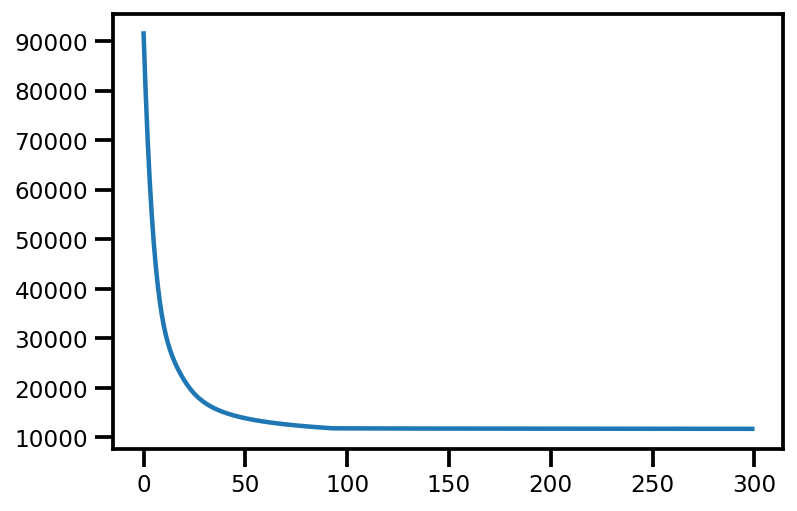

In [156]:
plt.plot(losses)

In [157]:
for ikey, val in model.vars().items():
    print(ikey, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance [7.5885353] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RBF).length_scale [1.8449624 0.7884489 0.3830533 2.0350282 1.4383912 2.2769215] <class 'jax.interpreters.xla.DeviceArray'> (6,)
(ExactGP).noise [3.2660477] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [158]:
model.cache_factorizations(X=Xtrain_scaled, y=ytrain_scaled.squeeze(),)


In [159]:

mu, cov = model.predict_f(Xtrain_scaled)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

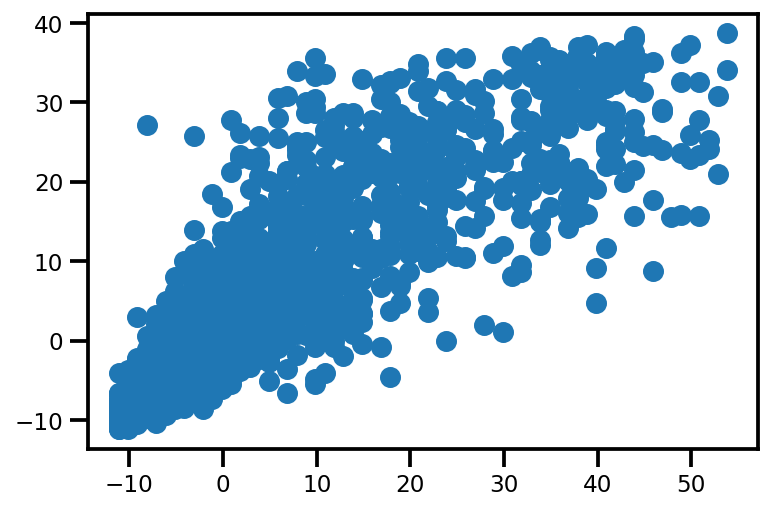

In [160]:
plt.scatter(ytrain_scaled.squeeze(), mu.squeeze())

In [161]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [162]:
ytrain.shape, mu.shape

((3000,), (3000, 1))

In [163]:
r2 = r2_score(ytrain_scaled.squeeze(), mu.squeeze())

print(r2)

r2 = mean_squared_error(ytrain_scaled.squeeze(), mu.squeeze())

print(r2)

0.8111534382993522
34.433083


In [164]:
%%time

# predict_f_jitted = jax.jit(jax.vmap(model.predict_f, in_axes=(0), out_axes=(0, 0)))
# mu, cov = predict_f_jitted(Xtest_scaled)

mu, cov = model.predict_f(Xtest_scaled)

CPU times: user 30.9 s, sys: 6.89 s, total: 37.8 s
Wall time: 2.92 s


In [165]:
mu.shape, cov.shape

((38430, 1), (38430, 38430))

In [166]:
Xtest_scaled.shape

(38430, 6)

In [167]:
import numpy as onp
r2 = r2_score(ytest_scaled.squeeze(), mu.squeeze())

print(r2)

r2 = mean_squared_error(ytest_scaled.squeeze(), mu.squeeze())

print(r2)

0.8084039473424952
35.42298


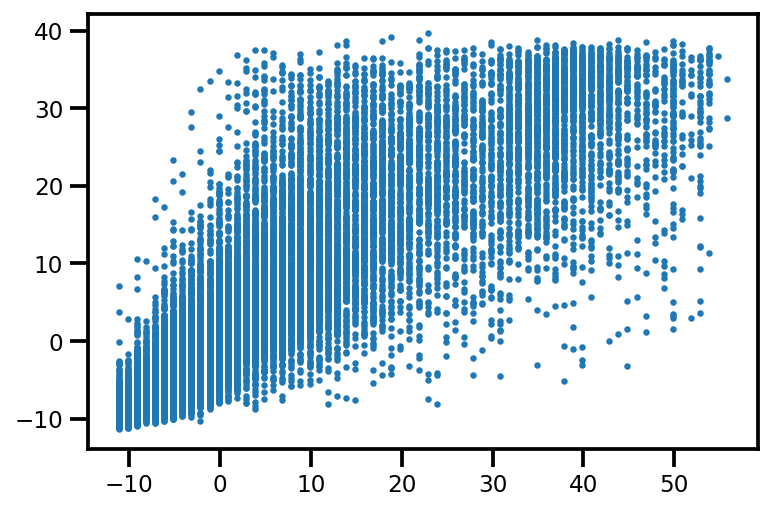

In [168]:
plt.scatter(ytest_scaled.squeeze(), mu.squeeze(), s=3)